# Principal Component Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Load and Preprocess the Dataset

In [2]:
iris = load_iris(as_frame=True)
X = iris.data[['petal length (cm)', 'petal width (cm)', 'sepal length (cm)']]

## Create the Algorithm from Scratch

In [3]:
class PCAFromScratch:    
    def __init__(self, n_components=None):
        self.n_components = n_components

    @staticmethod
    def get_variance_or_covariance(first_sample, second_sample):
        first_sample_mean = np.mean(first_sample)
        second_sample_mean = np.mean(second_sample)
        observations_nr = len(first_sample)
        
        return np.sum(
            (first_sample - first_sample_mean) * (second_sample - second_sample_mean)
        ) / (observations_nr - 1)
        
    def get_covariance_matrix(self, x_param, features_nr):
        matrix = []
        
        for i in range(features_nr):
            row = []
  
            for j in range(features_nr):
                first_sample = x_param[:, i]
                second_sample = x_param[:, j]
                variance_or_covariance = self.get_variance_or_covariance(first_sample, 
                                                                         second_sample)
                
                row.append(variance_or_covariance)
                
            matrix.append(row)
            
        return np.array(matrix)
    
    @staticmethod
    def get_projection(q_j, a_i):
        inner_q_j_a_i = np.dot(q_j, a_i)
        inner_q_j_q_j = np.dot(q_j, q_j)
        
        return inner_q_j_a_i / inner_q_j_q_j * q_j

    def run_gram_schmidt_process(self, given_matrix, matrix_dimension):
        orthonormal_vectors = []
        
        for i in range(matrix_dimension):
            a_i = given_matrix[:, i].astype('float64')
            u_i = a_i
                
            for j in range(i):
                q_j = orthonormal_vectors[j]
                proj_q_j_a_i = self.get_projection(q_j, a_i)
                u_i -= proj_q_j_a_i
                
            q_i = u_i / np.linalg.norm(u_i)
            
            orthonormal_vectors.append(q_i)
    
        orthogonal_matrix = np.column_stack(orthonormal_vectors)
        upper_triangular_matrix = np.dot(orthogonal_matrix.T, given_matrix)
            
        return orthogonal_matrix, upper_triangular_matrix

    def run_qr_algorithm(self, given_matrix, matrix_dimension):
        given_matrix_k = given_matrix
        eigenvectors = np.identity(matrix_dimension)

        for k in range(20):
            orthogonal_matrix_k, upper_triangular_matrix_k = self.run_gram_schmidt_process(
                given_matrix_k, matrix_dimension
            )
            given_matrix_k = np.dot(upper_triangular_matrix_k, orthogonal_matrix_k)
            eigenvectors = np.dot(eigenvectors, orthogonal_matrix_k)
    
        eigenvalues = np.diag(given_matrix_k)
            
        return eigenvalues, eigenvectors
    
    def get_feature_vector(self, eigenvalues, eigenvectors):
        desc_eigenvalues = np.argsort(eigenvalues)[::-1]
        selected_eigenvector_indexes = desc_eigenvalues[:self.n_components]
        
        return eigenvectors[:, selected_eigenvector_indexes]
    
    @staticmethod
    def get_plot_ax_limits(x_scaled, x_recast):
        plot_3d_ax_limits = []
        plot_2d_ax_limits = []                    

        for i in range(3):
            feature_values = x_scaled[:, i]
            
            plot_3d_ax_limits.append([min(feature_values), max(feature_values)])

        for i in range(2):
            feature_values = x_recast[:, i]
            
            plot_2d_ax_limits.append([min(feature_values), max(feature_values)])
            
        return plot_3d_ax_limits, plot_2d_ax_limits
    
    @staticmethod
    def plot_x_scaled(frame, ax1, x_scaled, plot_3d_ax_limits):
        ax1.clear()
        ax1.view_init(azim=frame * 2, elev=30)
        ax1.set_xlim(plot_3d_ax_limits[0])
        ax1.set_ylim(plot_3d_ax_limits[1])
        ax1.set_zlim(plot_3d_ax_limits[2])
        ax1.scatter(x_scaled[:, 0], x_scaled[:, 1], x_scaled[:, 2], edgecolors='black')
        ax1.set_title("Features in Three Dimensions")
        ax1.set_xlabel('petal length (cm)')
        ax1.set_ylabel('petal width (cm)')
        ax1.set_zlabel('sepal length (cm)')
    
    @staticmethod
    def animate_x_recast(ax2, x_recast, plot_2d_ax_limits):
        ax2.clear()
        ax2.set_xlim(plot_2d_ax_limits[0])
        ax2.set_ylim(plot_2d_ax_limits[1])
        ax2.axhline(0, color='black')
        ax2.axvline(0, color='black')
        ax2.scatter(x_recast[:, 0], x_recast[:, 1], edgecolors='black')
        ax2.set_axisbelow(True)
        ax2.grid(color='grey')
        ax2.set_title("Features in Two Dimensions")
        ax2.set_xlabel('first principal component')
        ax2.set_ylabel('second principal component')

    def animate(self, frame, ax1, ax2, x_scaled, x_recast, plot_3d_ax_limits, plot_2d_ax_limits):
        self.plot_x_scaled(frame, ax1, x_scaled, plot_3d_ax_limits)
        self.animate_x_recast(ax2, x_recast, plot_2d_ax_limits)
    
    def fit_transform(self, x_scaled, create_animation=False):
        features_nr = x_scaled.shape[1]
        
        if self.n_components is None:
            self.n_components = features_nr

        covariance_matrix = self.get_covariance_matrix(x_scaled, features_nr)
        eigenvalues, eigenvectors = self.run_qr_algorithm(covariance_matrix, features_nr)
        feature_vector = self.get_feature_vector(eigenvalues, eigenvectors)
        x_recast = np.dot(feature_vector.T, x_scaled.T).T

        if create_animation:
            if x_scaled.shape[1] != 3:
                raise Exception(("This Principal Component Analysis animation only supports "
                                 "three-dimensional features!"))
            
            if self.n_components != 2:
                raise Exception(("This Principal Component Analysis animation requires "
                                 "'n_components' to be 2!"))
    
            fig = plt.figure(figsize=plt.figaspect(2.))
            ax1 = fig.add_subplot(2, 1, 1, projection='3d')
            ax2 = fig.add_subplot(2, 1, 2)
            plot_3d_ax_limits, plot_2d_ax_limits = self.get_plot_ax_limits(x_scaled, x_recast)
            animation = FuncAnimation(fig, self.animate, 180, fargs=(
                ax1, ax2, x_scaled, x_recast, plot_3d_ax_limits, plot_2d_ax_limits
            ))

            fig.subplots_adjust(left=0.2, bottom=0.1, top=0.9, hspace=0.3)
            animation.save('principal_component_analysis.gif', writer=PillowWriter(fps=20), 
                           dpi=200)

        return x_recast

## Create an Animation and Compare Implementations

In [4]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

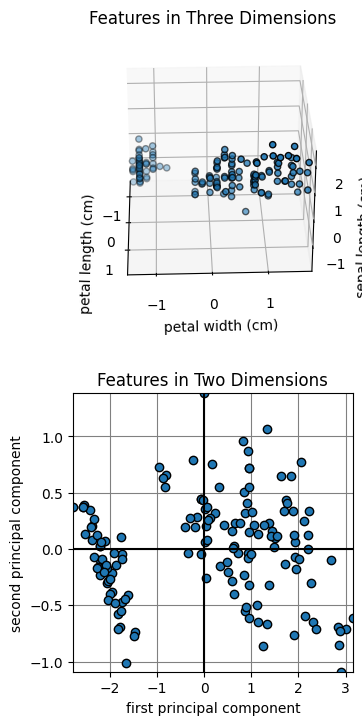

In [5]:
model_from_scratch = PCAFromScratch(n_components=2)
    
X_transformed_from_scratch = model_from_scratch.fit_transform(X_scaled, create_animation=True)

In [6]:
model = PCA(n_components=2)

X_transformed = model.fit_transform(X_scaled)

In [7]:
# Eigenvectors may flip signs; compare using abs() for a fair check
np.allclose(np.abs(X_transformed_from_scratch), np.abs(X_transformed))

True